In [1]:
# Mount Google Drive to access the dataset folder
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Set the path to the folder containing the datasets
folder_path = '/content/drive/MyDrive/DSA2025Spring/TermProjectDatas/'

Mounted at /content/drive


In [3]:
gdp_data = pd.read_excel(folder_path + 'GDP Data.xlsx', header=1)
gdp_data.columns = gdp_data.columns.str.strip()
gdp_data = gdp_data.rename(columns={'Country Name': 'Country'})

# Convert to long format using melt
gdp_data = gdp_data.melt(id_vars='Country', var_name='Year', value_name='GDP')
gdp_data['Year'] = gdp_data['Year'].astype(str)

In [4]:
military_data = pd.read_excel(folder_path + 'Military.xlsx', header=1)
military_data.columns = military_data.columns.str.strip()
military_data = military_data.rename(columns={'Military Personnel': 'Military'})
military_data['Year'] = military_data['Year'].astype(str)

In [5]:
# Load and clean HDI data
hdi_data = pd.read_excel(folder_path + 'Human Dev Index.xlsx', header=1)
hdi_data.columns = hdi_data.columns.str.strip()
hdi_data = hdi_data.rename(columns={'Country Name': 'Country', 'Index': 'HDI'})

In [6]:
# Load and clean space debris data
space_debris_data = pd.read_csv(folder_path + 'SpaceDebrisStats.csv', sep=';')
space_debris_data.columns = space_debris_data.columns.str.strip()
space_debris_data = space_debris_data.rename(columns={
    'Space Debris Contributor': 'Country',
    '# of Space Debris': 'Debris'
})

In [10]:
# Load and reshape trade data
raw_trade = pd.read_excel(folder_path + 'Trade.xlsx', header=None)
years = [str(year) for year in range(2000, 2024)]

# Extract relevant data and assign column names
trade_data = raw_trade.iloc[1:, :25]
trade_data.columns = ['Country'] + years
trade_data = trade_data[trade_data['Country'] != 'Country']

# Convert to long format
trade_melted = trade_data.melt(id_vars='Country', var_name='Year', value_name='Trade')
trade_melted['Year'] = trade_melted['Year'].astype(str)

In [11]:
# Filter each dataset to include only data between 2000 and 2016
year_range = [str(y) for y in range(2000, 2017)]

gdp_data = gdp_data[gdp_data['Year'].isin(year_range)]
trade_melted = trade_melted[trade_melted['Year'].isin(year_range)]
military_data = military_data[military_data['Year'].isin(year_range)]

In [12]:
# 1. Read raw data without headers
raw_gdp = pd.read_excel(folder_path + 'GDP Data.xlsx', header=None)

# 2. First row contains year labels; extract and convert to strings
years = [str(int(year)) for year in raw_gdp.iloc[0, 1:] if pd.notna(year)]

# 3. Data starts after the first row
gdp_data = raw_gdp.iloc[1:, :len(years)+1]
gdp_data.columns = ['Country'] + years

# 4. Remove redundant header rows (e.g., rows with "Country" as country name)
gdp_data = gdp_data[gdp_data['Country'] != 'Country']

In [15]:
# Extract the relevant data and assign column names
gdp_data = raw_gdp.iloc[1:, :len(years)+1]
gdp_data.columns = ['Country'] + years
gdp_data = gdp_data[gdp_data['Country'] != 'Country']

# Convert GDP data to long format
gdp_data = gdp_data.melt(id_vars='Country', var_name='Year', value_name='GDP')
gdp_data['Year'] = gdp_data['Year'].astype(str)

In [16]:
# Manually define year labels
years = [str(y) for y in range(2000, 2024)]

# Select data from the first row onward, keep first 25 columns (1 for country + 24 for years)
gdp_data = raw_gdp.iloc[1:, :25]
gdp_data.columns = ['Country'] + years

# Remove any remaining header row
gdp_data = gdp_data[gdp_data['Country'] != 'Country']

In [18]:
gdp_data = gdp_data.melt(id_vars='Country', var_name='Year', value_name='GDP')
gdp_data['Year'] = gdp_data['Year'].astype(str)

In [19]:
# --- Merge GDP and Trade datasets ---
merged = pd.merge(gdp_data, trade_melted, on=['Country', 'Year'], how='inner')

# --- Add Military data ---
merged = pd.merge(merged, military_data, on=['Country', 'Year'], how='inner')

# --- Add HDI data ---
merged = pd.merge(merged, hdi_data[['Country', 'HDI']], on='Country', how='left')

# --- Add Space Debris data ---
merged = pd.merge(merged, space_debris_data[['Country', 'Debris']], on='Country', how='left')

In [20]:
# 1. Fill missing values in Debris column with 0
merged['Debris'] = merged['Debris'].fillna(0)

# 2. Drop all remaining rows with missing values (e.g., GDP, Trade, Military, HDI)
#    Debris column will be preserved since it no longer contains missing values
merged_cleaned = merged.dropna()

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Create a copy of the cleaned dataset
normalized_data = merged_cleaned.copy()

# Adjust HDI scale (convert from 0–100 to 0–1)
normalized_data['HDI'] = normalized_data['HDI'] / 100

# Apply log transformation to selected columns
log_cols = ['GDP', 'Trade', 'Military']
for col in log_cols:
    normalized_data[col] = np.log1p(normalized_data[col])

# Apply Min-Max normalization to selected columns
scaler = MinMaxScaler()
minmax_cols = ['GDP', 'Trade', 'Military', 'HDI', 'Debris']
normalized_data[minmax_cols] = scaler.fit_transform(normalized_data[minmax_cols])
normalized_data['Debris'] = scaler.fit_transform(normalized_data[['Debris']]).flatten()

In [23]:
# 1. Apply log transformation with a small epsilon to avoid log(0)
epsilon = 1e-6
normalized_data['Debris_log'] = np.log1p(normalized_data['Debris'] + epsilon)

# 2. Apply Min-Max normalization to the log-transformed debris values
scaler = MinMaxScaler()
normalized_data['Debris'] = scaler.fit_transform(normalized_data[['Debris_log']])

# 3. Remove the temporary 'Debris_log' column
normalized_data.drop(columns=['Debris_log'], inplace=True)

In [24]:
# 1. Identify the top 20 countries for each variable (based on total or highest value)
top20_gdp = gdp_data.groupby('Country')['GDP'].sum().sort_values(ascending=False).head(20).index
top20_trade = trade_melted.groupby('Country')['Trade'].sum().sort_values(ascending=False).head(20).index
top20_military = military_data.groupby('Country')['Military'].sum().sort_values(ascending=False).head(20).index
top20_hdi = hdi_data.sort_values('HDI', ascending=False).head(20)['Country']
top20_debris = space_debris_data.sort_values('Debris', ascending=False).head(20)['Country']

# 2. Combine all top country sets
top_countries = set(top20_gdp) | set(top20_trade) | set(top20_military) | set(top20_hdi) | set(top20_debris)

# 3. Filter each melted dataset to include only top countries
gdp_top = gdp_data[gdp_data['Country'].isin(top_countries)]
trade_top = trade_melted[trade_melted['Country'].isin(top_countries)]
military_top = military_data[military_data['Country'].isin(top_countries)]
hdi_top = hdi_data[hdi_data['Country'].isin(top_countries)]
debris_top = space_debris_data[space_debris_data['Country'].isin(top_countries)]

# 4. Merge datasets (GDP + Trade + Military + HDI + Debris)
merged_top = pd.merge(gdp_top, trade_top, on=['Country', 'Year'], how='inner')
merged_top = pd.merge(merged_top, military_top, on=['Country', 'Year'], how='inner')
merged_top = pd.merge(merged_top, hdi_top, on='Country', how='left')
merged_top = pd.merge(merged_top, debris_top, on='Country', how='left')

# 5. Fill missing values in Debris with 0, and drop rows with other missing values
merged_top['Debris'] = merged_top['Debris'].fillna(0)
merged_top_cleaned = merged_top.dropna()

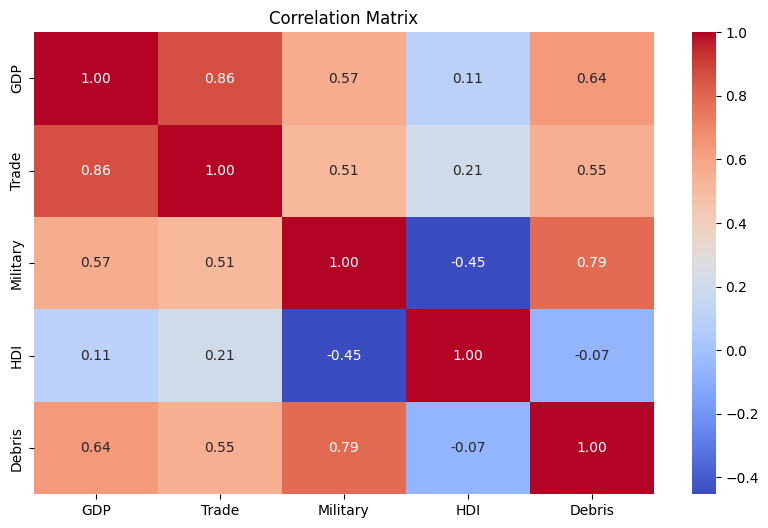

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select only numerical columns (excluding Country and Year)
numeric_cols = merged_top_cleaned.select_dtypes(include='number')

# 2. Compute correlation matrix
corr_matrix = numeric_cols.corr()

# 3. Plot heatmap of correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

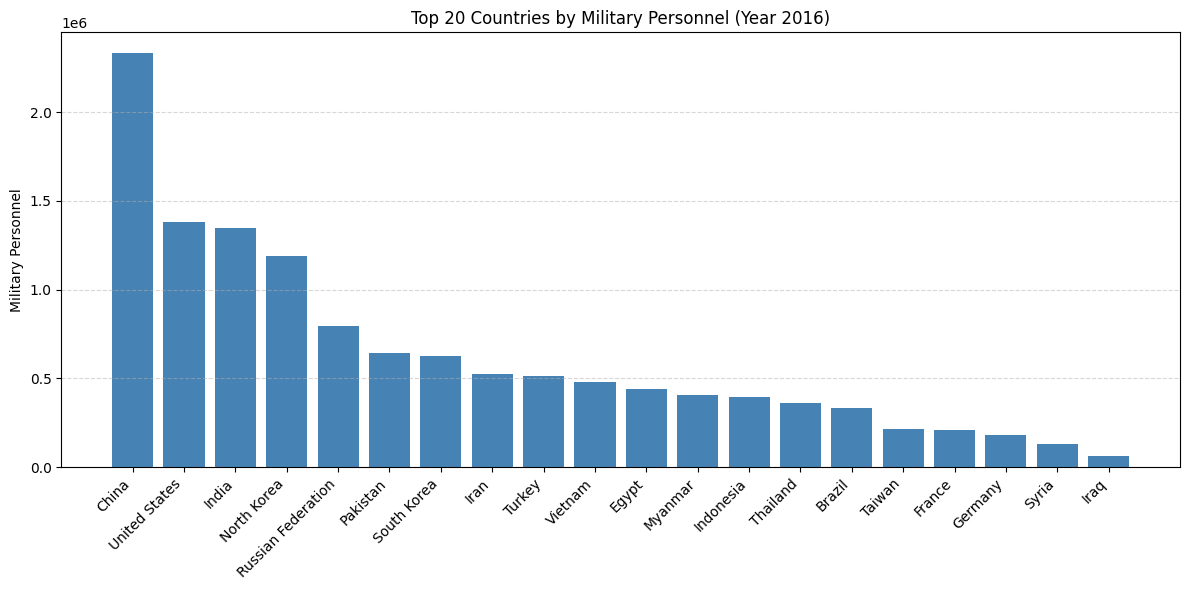

In [28]:
# 1. Filter military data for countries in top20_military
military_top20_data = military_data[military_data['Country'].isin(top20_military)]

# 2. Select data from the most recent year (e.g., 2016)
latest_year = military_top20_data['Year'].max()
military_latest = military_top20_data[military_top20_data['Year'] == latest_year]

# 3. Sort by military personnel in descending order
military_latest_sorted = military_latest.sort_values(by='Military', ascending=False)

# 4. Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(military_latest_sorted['Country'], military_latest_sorted['Military'], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Countries by Military Personnel (Year {})".format(latest_year))
plt.ylabel("Military Personnel")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
# Calculate total GDP for these countries (2000–2016)
top20_gdp_df = gdp_data[gdp_data['Country'].isin(top20_gdp)] \
    .groupby('Country', as_index=False)['GDP'].sum() \
    .sort_values(by='GDP', ascending=False)

<ipython-input-30-e567221e703a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_filtered['Country'] = gdp_filtered['Country'].replace('Turkiye', 'Turkey')


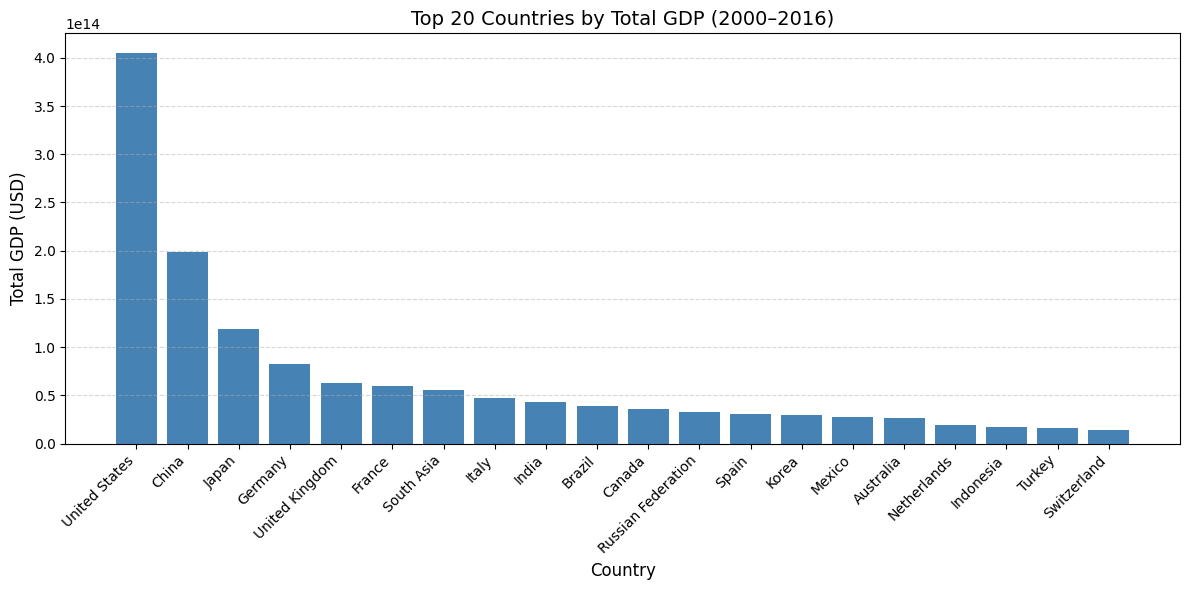

In [30]:
# Remove non-country entries from GDP data
non_countries = [
    'High income', 'Middle income', 'Low income', 'Lower middle income', 'Upper middle income',
    'North America', 'Arab World', 'Fragile and conflict affected situations',
    'Sub-Saharan Africa', 'Central Europe and the Baltics', 'Africa Eastern and Southern'
]

gdp_filtered = gdp_data[~gdp_data['Country'].isin(non_countries)]
gdp_filtered['Country'] = gdp_filtered['Country'].replace('Turkiye', 'Turkey')

# Calculate total GDP per country and select the top 20
top20_gdp = gdp_filtered.groupby('Country', as_index=False)['GDP'].sum().sort_values(by='GDP', ascending=False).head(20)

# Bar chart (with scientific notation)
plt.figure(figsize=(12, 6))
bars = plt.bar(top20_gdp['Country'], top20_gdp['GDP'], color='steelblue')

plt.title('Top 20 Countries by Total GDP (2000–2016)', fontsize=14)
plt.ylabel('Total GDP (USD)', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # Scientific notation

plt.tight_layout()
plt.show()


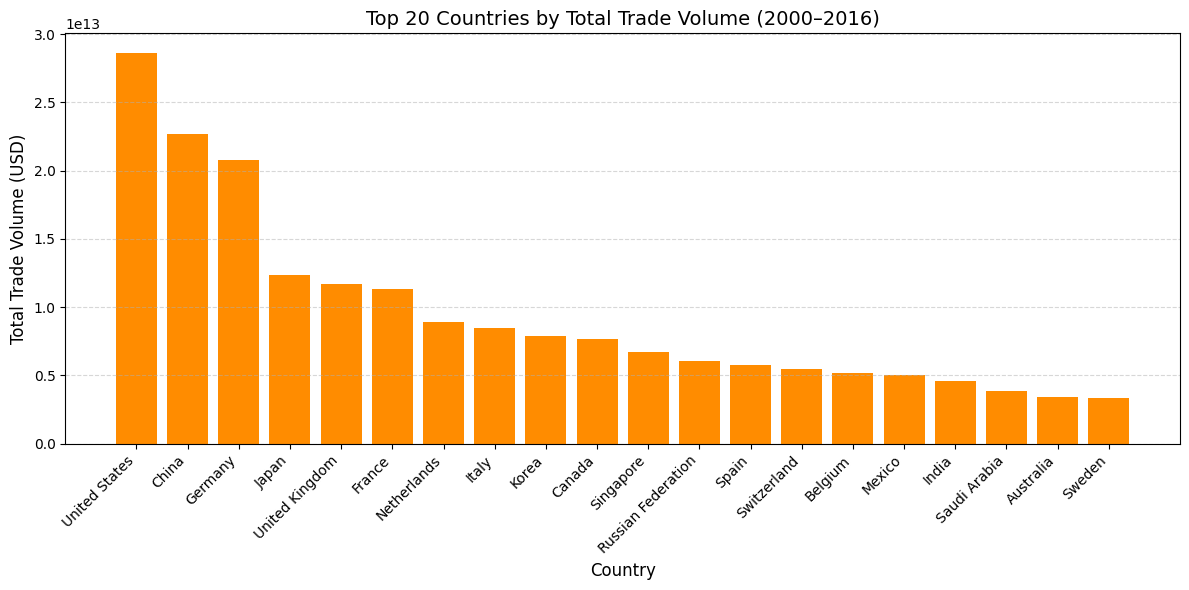

In [32]:
# 1. Define non-country entities to exclude
non_countries = [
    'High income', 'Middle income', 'Low income', 'Lower middle income', 'Upper middle income',
    'North America', 'Arab World', 'Fragile and conflict affected situations',
    'Sub-Saharan Africa', 'Central Europe and the Baltics', 'World', 'Euro area', 'Latin America & Caribbean',
    'South Asia', 'Middle East & North Africa (excluding high income)'
]

# 2. Filter out non-country entries from trade data
trade_filtered = trade_melted[~trade_melted['Country'].isin(non_countries)]

# 3. Calculate total trade volume per country and select top 20
top20_trade = trade_filtered.groupby('Country', as_index=False)['Trade'].sum().sort_values(by='Trade', ascending=False).head(20)

# 4. Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(top20_trade['Country'], top20_trade['Trade'], color='darkorange')

plt.title('Top 20 Countries by Total Trade Volume (2000–2016)', fontsize=14)
plt.ylabel('Total Trade Volume (USD)', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # Scientific notation

plt.tight_layout()
plt.show()

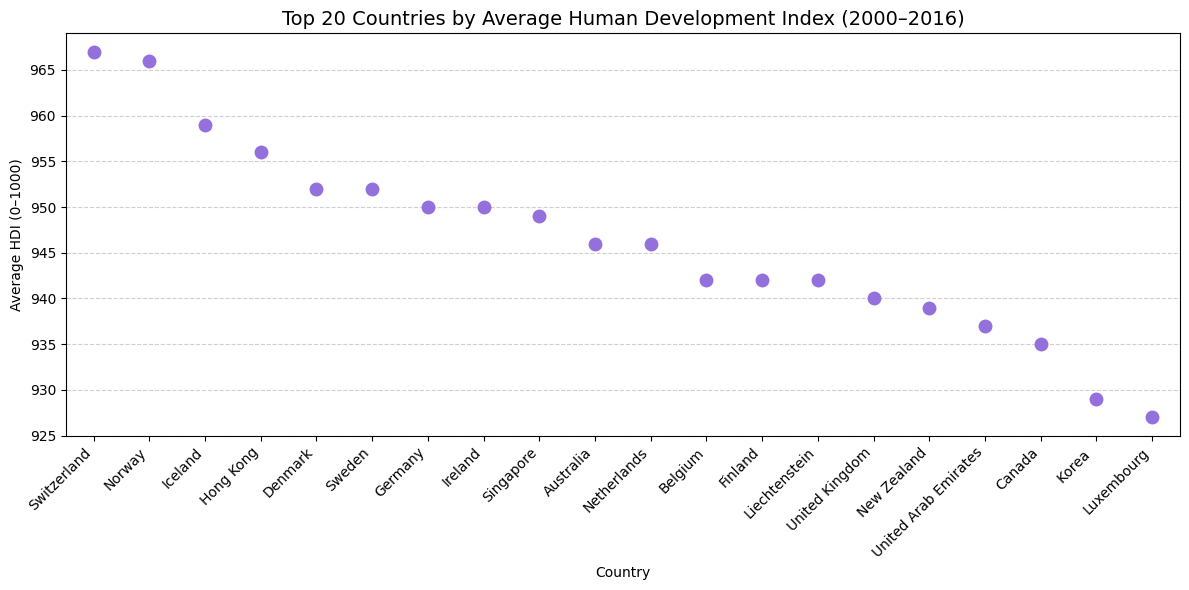

In [33]:
# Full DataFrame of top 20 HDI countries
top20_hdi_df = hdi_data[hdi_data['Country'].isin(top20_hdi)]

plt.figure(figsize=(12, 6))
sns.stripplot(data=top20_hdi_df, x='Country', y='HDI', color='mediumpurple', size=10, jitter=0.25)
plt.title("Top 20 Countries by Average Human Development Index (2000–2016)", fontsize=14)
plt.ylabel("Average HDI (0–1000)")
plt.xlabel("Country")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-34-fc0fee84d2bf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  space_debris_filtered['LogPlus1_Debris'] = np.log10(space_debris_filtered['Debris'] + 1)


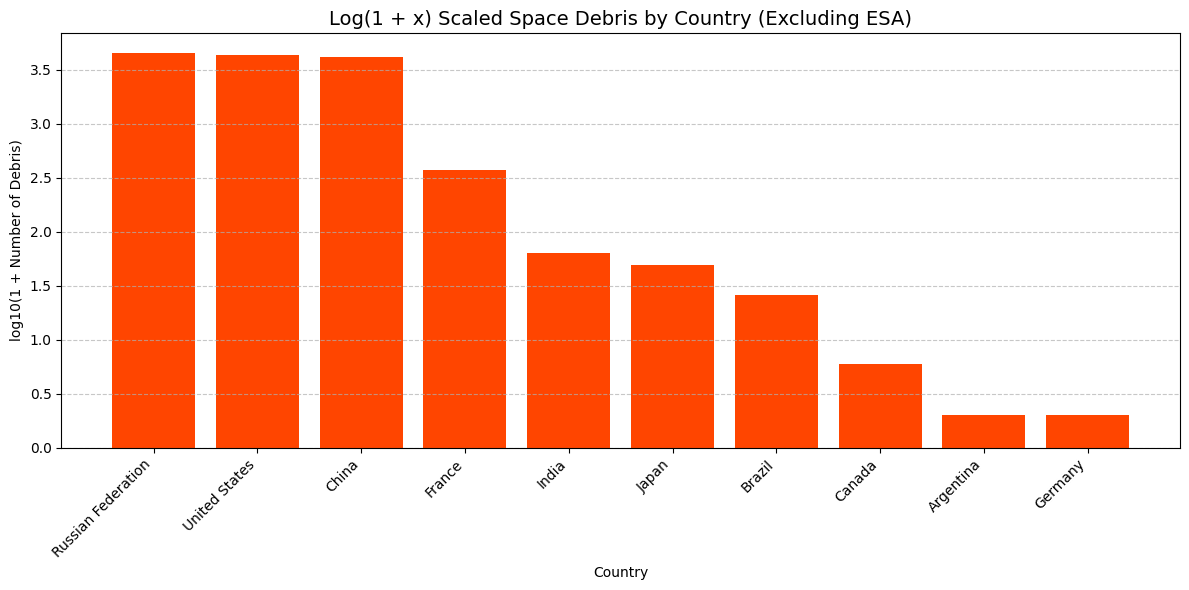

In [34]:
# Read the dataset and clean column names
space_debris_data = pd.read_csv(folder_path + "SpaceDebrisStats.csv", delimiter=';')
space_debris_data.columns = ['Country', 'Debris']
space_debris_data['Debris'] = pd.to_numeric(space_debris_data['Debris'], errors='coerce')

# Remove the European Space Agency entry
space_debris_filtered = space_debris_data[space_debris_data['Country'] != 'European Space Agency']

# Apply log(1 + x) transformation
space_debris_filtered['LogPlus1_Debris'] = np.log10(space_debris_filtered['Debris'] + 1)

# Sort countries by debris count
space_debris_sorted = space_debris_filtered.sort_values(by='Debris', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(space_debris_sorted['Country'], space_debris_sorted['LogPlus1_Debris'], color='orangered')
plt.title('Log(1 + x) Scaled Space Debris by Country (Excluding ESA)', fontsize=14)
plt.xlabel('Country')
plt.ylabel('log10(1 + Number of Debris)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [37]:
from scipy.stats import pearsonr, spearmanr

# Indicators to test against Debris
indicators = ['GDP', 'Trade', 'Military', 'HDI']
results = []

# Loop through each indicator and calculate Pearson & Spearman correlation with Debris
for indicator in indicators:
    subset = merged_top_cleaned[[indicator, 'Debris']].dropna()

    if subset['Debris'].nunique() > 1 and subset[indicator].nunique() > 1:
        pearson_corr, pearson_p = pearsonr(subset[indicator], subset['Debris'])
        spearman_corr, spearman_p = spearmanr(subset[indicator], subset['Debris'])

        results.append({
            'Indicator': indicator,
            'Pearson Correlation': round(pearson_corr, 4),
            'Pearson p-value': format(pearson_p, '.2e'),
            'Spearman Correlation': round(spearman_corr, 4),
            'Spearman p-value': format(spearman_p, '.2e'),
            'Sample Size': len(subset)
        })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Print the result table
print("\n=== Hypothesis Test Results: Correlation with Space Debris ===\n")
print(results_df.to_string(index=False))


=== Hypothesis Test Results: Correlation with Space Debris ===

Indicator  Pearson Correlation Pearson p-value  Spearman Correlation Spearman p-value  Sample Size
      GDP               0.6356        2.10e-59                0.6434         2.83e-61          513
    Trade               0.5531        1.95e-42                0.4838         1.84e-31          513
 Military               0.7882       8.32e-110                0.5901         1.87e-49          513
      HDI              -0.0664        1.33e-01               -0.3451         8.65e-16          513


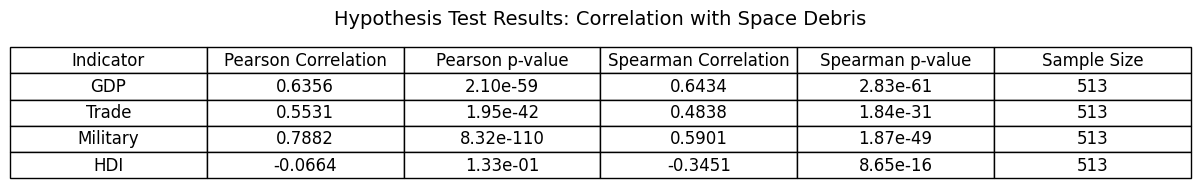

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data dictionary
data = {
    "Indicator": ["GDP", "Trade", "Military", "HDI"],
    "Pearson Correlation": [0.6356, 0.5531, 0.7882, -0.0664],
    "Pearson p-value": ["2.10e-59", "1.95e-42", "8.32e-110", "1.33e-01"],
    "Spearman Correlation": [0.6434, 0.4838, 0.5901, -0.3451],
    "Spearman p-value": ["2.83e-61", "1.84e-31", "1.87e-49", "8.65e-16"],
    "Sample Size": [513, 513, 513, 513]
}

# Create DataFrame
df_results = pd.DataFrame(data)

# Plot the table
plt.figure(figsize=(12, 2))
table = plt.table(cellText=df_results.values,
                  colLabels=df_results.columns,
                  loc='center',
                  cellLoc='center',
                  colLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)
plt.axis('off')
plt.title("Hypothesis Test Results: Correlation with Space Debris", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


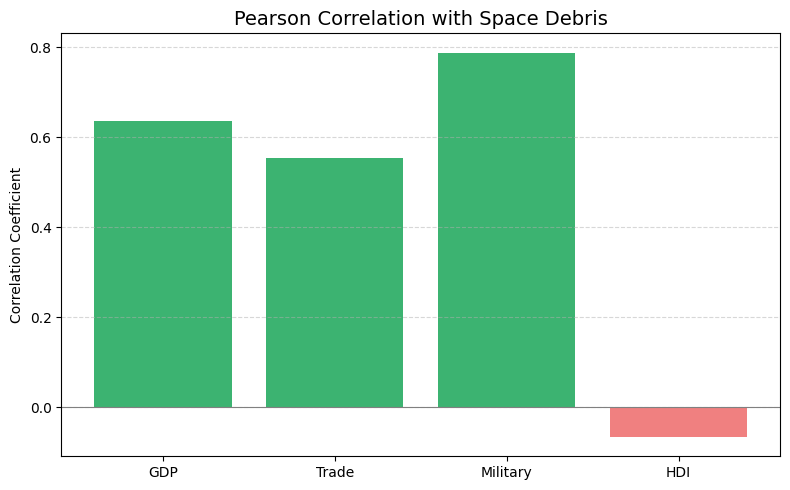

In [46]:
import matplotlib.pyplot as plt

# Data
indicators = ['GDP', 'Trade', 'Military', 'HDI']
pearson_corr = [0.6356, 0.5531, 0.7882, -0.0664]

# Custom colors
colors = ['mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'lightcoral']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(indicators, pearson_corr, color=colors)

# Aesthetic improvements
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Pearson Correlation with Space Debris', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
